In [1]:
import os
import pandas as pd
import numpy as np
from statsforecast import StatsForecast

from lib.utils import get_polygon_root, get_polygon_freq, log_returns

/Users/beneverman/Documents/Coding/bp-quant/model-experiments-v1/venv/lib/python3.10/site-packages/statsforecast/core.py:25: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
data = f"{get_polygon_root()}/sp500-5yr-hourly"
all_tickers = set([path.split("_")[0] for path in os.listdir(data) if path.endswith(".csv")])
all_paths = set([path for path in os.listdir(data) if path.endswith(".csv")])

In [3]:
tickers = ['MSFT']
paths = [path for path in all_paths if path.startswith(tickers[0])]

In [5]:
df = pd.read_csv(f"{data}/{paths[0]}")

## Steps
1. get df formatted into params
   1. date param (str YYYY-MM-DD HH:MM:SS)
   2. y value (log return series)
   3. series uid (ticker)

In [6]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocess dataframe for statsforecast
    """
    df = df.ffill() # fill missing values with previous value
    df = df.dropna() # drop remaining missing values (first row)
    assert df.isnull().sum().sum() == 0, "Missing values in dataframe"

    df.rename(columns={'est': 'ds'}, inplace=True) # rename column to ds
    df.sort_values(by='ds', inplace=True) # sort by ds (have to do this before getting log returns)
    df.reset_index(drop=True, inplace=True) # reset index after sorting

    df.loc[:, 'log_rt'] = log_returns(df['close']) # get log returns

    df = df[['ticker', 'log_rt', 'ds']].rename(columns={
    'log_rt' : 'y',
    'ticker' : 'unique_id'
    }) # select only relevant columns and rename

    return df

In [7]:
returns = preprocess(df)

## Train the models

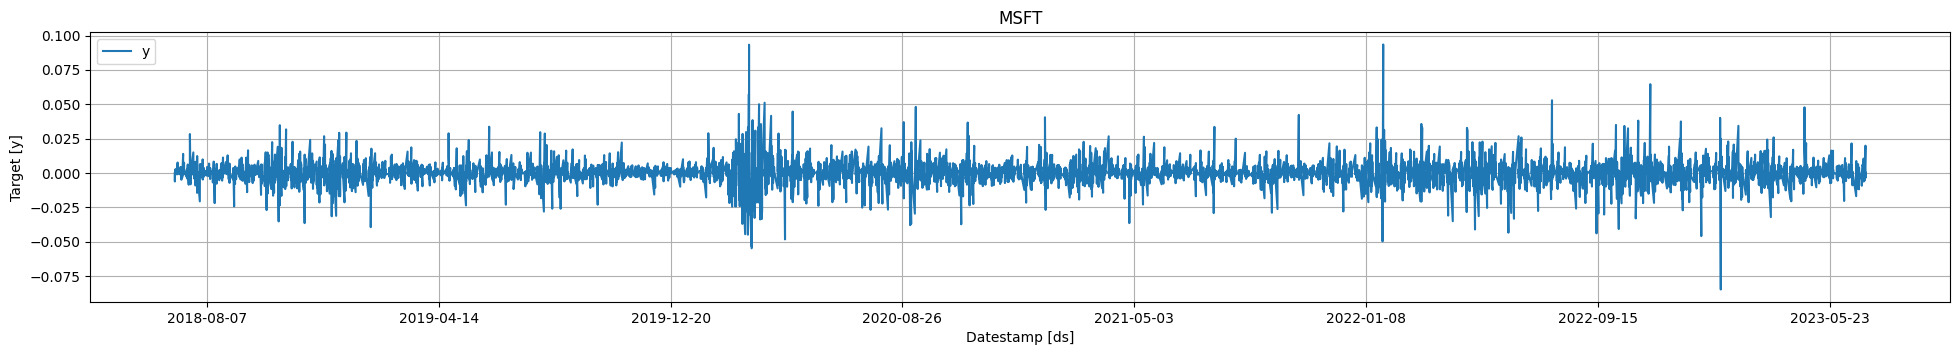

In [41]:
StatsForecast.plot(returns)

In [42]:
from statsforecast.models import (
    GARCH, 
    ARCH, 
    Naive
)

In [82]:
models = [
        Naive()
]

In [83]:
sf = StatsForecast(
    df = returns, 
    models = models, 
    freq = get_polygon_freq(),
    n_jobs = -1
)

In [67]:
crossvalidation_df = sf.cross_validation(
    df = returns,
    h = 7, # 1 day ahead
    step_size = 7, # 1 day step size
    n_windows = 20, # 20 windows
) 

In [68]:
crossvalidation_df = crossvalidation_df.reset_index()
crossvalidation_df.rename(columns = {'y' : 'actual'}, inplace = True)
crossvalidation_df

,unique_id,ds,cutoff,actual,ARCH(1),ARCH(2),"GARCH(1,1)","GARCH(1,2)","GARCH(2,2)","GARCH(2,1)",Naive
0,MSFT,2023-06-06 13:00:00,2023-06-06 12:00:00,0.002699,0.218291,0.187406,0.068375,0.214065,0.197166,0.219896,0.000751
1,MSFT,2023-06-06 14:00:00,2023-06-06 12:00:00,-0.000629,-0.082212,-0.070581,-0.025751,-0.080621,-0.074256,-0.082817,0.000751
2,MSFT,2023-06-06 15:00:00,2023-06-06 12:00:00,-0.000420,-0.070979,-0.060937,-0.022233,-0.069605,-0.064111,-0.071501,0.000751
3,MSFT,2023-06-06 16:00:00,2023-06-06 12:00:00,-0.000026,-0.144193,-0.123792,-0.045165,-0.141402,-0.130239,-0.145253,0.000751
4,MSFT,2023-06-07 09:00:00,2023-06-06 12:00:00,-0.020359,0.116300,0.099845,0.036428,0.114048,0.105045,0.117155,0.000751
...,...,...,...,...,...,...,...,...,...,...,...
135,MSFT,2023-06-30 12:00:00,2023-06-29 17:00:00,-0.000858,-0.038233,-0.039381,-0.047011,-0.107890,-0.052278,-0.088267,0.019853
136,MSFT,2023-06-30 13:00:00,2023-06-29 17:00:00,-0.000932,-0.077669,-0.080001,-0.095501,-0.219177,-0.106202,-0.179312,0.019853
137,MSFT,2023-06-30 14:00:00,2023-06-29 17:00:00,-0.000617,0.062645,0.064526,0.077027,0.176778,0.085658,0.144625,0.019853
138,MSFT,2023-06-30 15:00:00,2023-06-29 17:00:00,0.000485,-0.166602,-0.171605,-0.204851,-0.470139,-0.227805,-0.384629,0.019853


/Users/beneverman/Documents/Coding/bp-quant/model-experiments-v1/venv/lib/python3.10/site-packages/statsforecast/core.py:1514: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["unique_id"] = df["unique_id"].astype(uid_dtype)


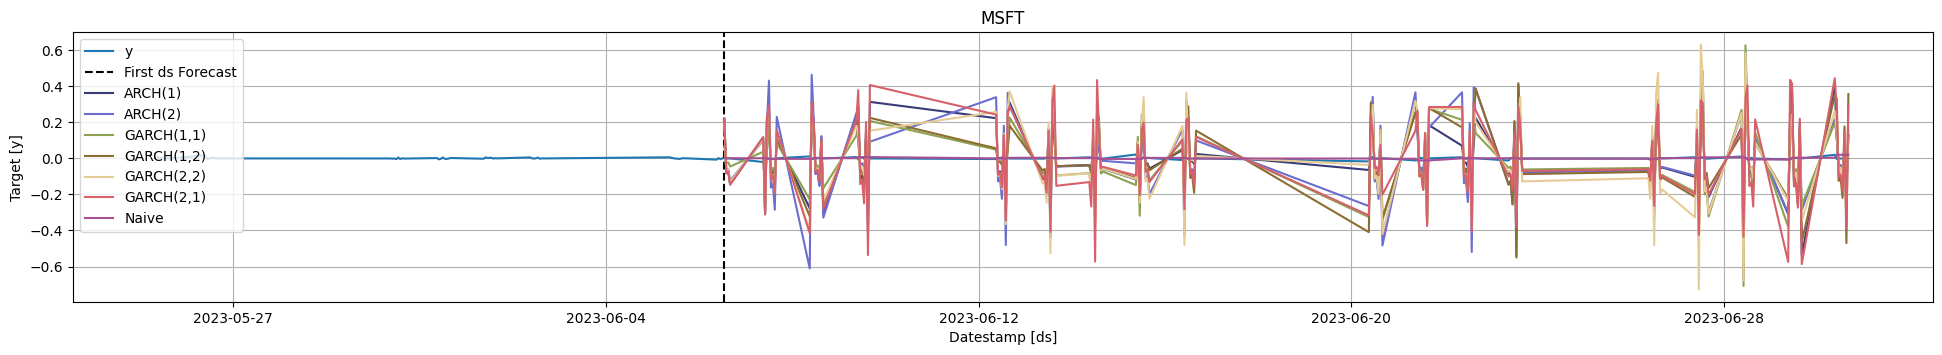

In [69]:
StatsForecast.plot(returns.tail(200), crossvalidation_df.drop(['cutoff', 'actual'], axis=1))

In [72]:
from datasetsforecast.losses import mae as mae_loss

In [73]:
def compute_cv_mae(crossvalidation_df):
    """Compute MAE for all models generated"""
    res = {}
    for mod in models: # loop through models
        res[mod] = mae_loss(crossvalidation_df['actual'], crossvalidation_df[str(mod)]) # compute MAE
    return pd.Series(res) # return as Series

In [74]:
mae_cv = crossvalidation_df.groupby(['unique_id', 'cutoff']).apply(compute_cv_mae)

mae = mae_cv.groupby('unique_id').mean()
mae.style.highlight_min(color = 'lightblue', axis = 1)

,ARCH(1),ARCH(2),"GARCH(1,1)","GARCH(1,2)","GARCH(2,2)","GARCH(2,1)",Naive
unique_id,,,,,,,
MSFT,0.155057,0.186279,0.158513,0.170011,0.198673,0.209302,0.005611


In [78]:
levels = [80, 95] # confidence levels for the prediction intervals 

forecasts = sf.forecast(h=7, level=levels)
forecasts = forecasts.reset_index()
forecasts.head()

,unique_id,ds,ARCH(1),ARCH(1)-lo-95,ARCH(1)-lo-80,ARCH(1)-hi-80,ARCH(1)-hi-95,ARCH(2),ARCH(2)-lo-95,ARCH(2)-lo-80,ARCH(2)-hi-80,ARCH(2)-hi-95,"GARCH(1,1)","GARCH(1,1)-lo-95","GARCH(1,1)-lo-80","GARCH(1,1)-hi-80","GARCH(1,1)-hi-95","GARCH(1,2)","GARCH(1,2)-lo-95","GARCH(1,2)-lo-80","GARCH(1,2)-hi-80","GARCH(1,2)-hi-95","GARCH(2,2)","GARCH(2,2)-lo-95","GARCH(2,2)-lo-80","GARCH(2,2)-hi-80","GARCH(2,2)-hi-95","GARCH(2,1)","GARCH(2,1)-lo-95","GARCH(2,1)-lo-80","GARCH(2,1)-hi-80","GARCH(2,1)-hi-95",Naive,Naive-lo-80,Naive-lo-95,Naive-hi-80,Naive-hi-95
0,MSFT,2023-07-03 09:00:00,0.203290,0.172591,0.183217,0.223363,0.233989,0.184503,0.159216,0.167969,0.201038,0.209790,0.413950,0.286662,0.330721,0.497180,0.541239,0.286250,0.225383,0.246451,0.326049,0.347117,0.308072,0.237571,0.261974,0.354170,0.378573,0.166488,0.145898,0.153025,0.179951,0.187078,-0.000898,-0.013126,-0.019600,0.011331,0.017804
1,MSFT,2023-07-03 10:00:00,-0.076563,-0.107262,-0.096636,-0.056490,-0.045864,-0.069487,-0.094774,-0.086022,-0.052953,-0.044200,-0.155901,-0.283190,-0.239131,-0.072672,-0.028612,-0.107807,-0.168674,-0.147606,-0.068008,-0.046940,-0.116025,-0.186526,-0.162124,-0.069927,-0.045524,-0.062702,-0.083292,-0.076165,-0.049239,-0.042112,-0.000898,-0.018192,-0.027346,0.016396,0.025551
2,MSFT,2023-07-03 11:00:00,-0.066102,-0.096801,-0.086175,-0.046029,-0.035403,-0.059993,-0.085280,-0.076527,-0.043459,-0.034706,-0.134600,-0.261888,-0.217829,-0.051371,-0.007312,-0.093077,-0.153944,-0.132876,-0.053278,-0.032210,-0.100173,-0.170674,-0.146271,-0.054074,-0.029671,-0.054135,-0.074725,-0.067598,-0.040672,-0.033545,-0.000898,-0.022078,-0.033291,0.020283,0.031495
3,MSFT,2023-07-03 12:00:00,-0.134284,-0.164983,-0.154357,-0.114211,-0.103585,-0.121874,-0.147162,-0.138409,-0.105340,-0.096587,-0.273437,-0.400725,-0.356666,-0.190208,-0.146149,-0.189084,-0.249951,-0.228883,-0.149285,-0.128217,-0.203498,-0.273999,-0.249596,-0.157400,-0.132997,-0.109974,-0.130565,-0.123438,-0.096511,-0.089384,-0.000898,-0.025355,-0.038302,0.023559,0.036506
4,MSFT,2023-07-03 13:00:00,0.108308,0.077609,0.088235,0.128381,0.139007,0.098298,0.073011,0.081764,0.114833,0.123586,0.220542,0.093253,0.137313,0.303771,0.347831,0.152506,0.091639,0.112708,0.192305,0.213374,0.164132,0.093631,0.118034,0.210231,0.234634,0.088700,0.068110,0.075237,0.102164,0.109290,-0.000898,-0.028242,-0.042717,0.026446,0.040921


/Users/beneverman/Documents/Coding/bp-quant/model-experiments-v1/venv/lib/python3.10/site-packages/statsforecast/core.py:1514: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["unique_id"] = df["unique_id"].astype(uid_dtype)


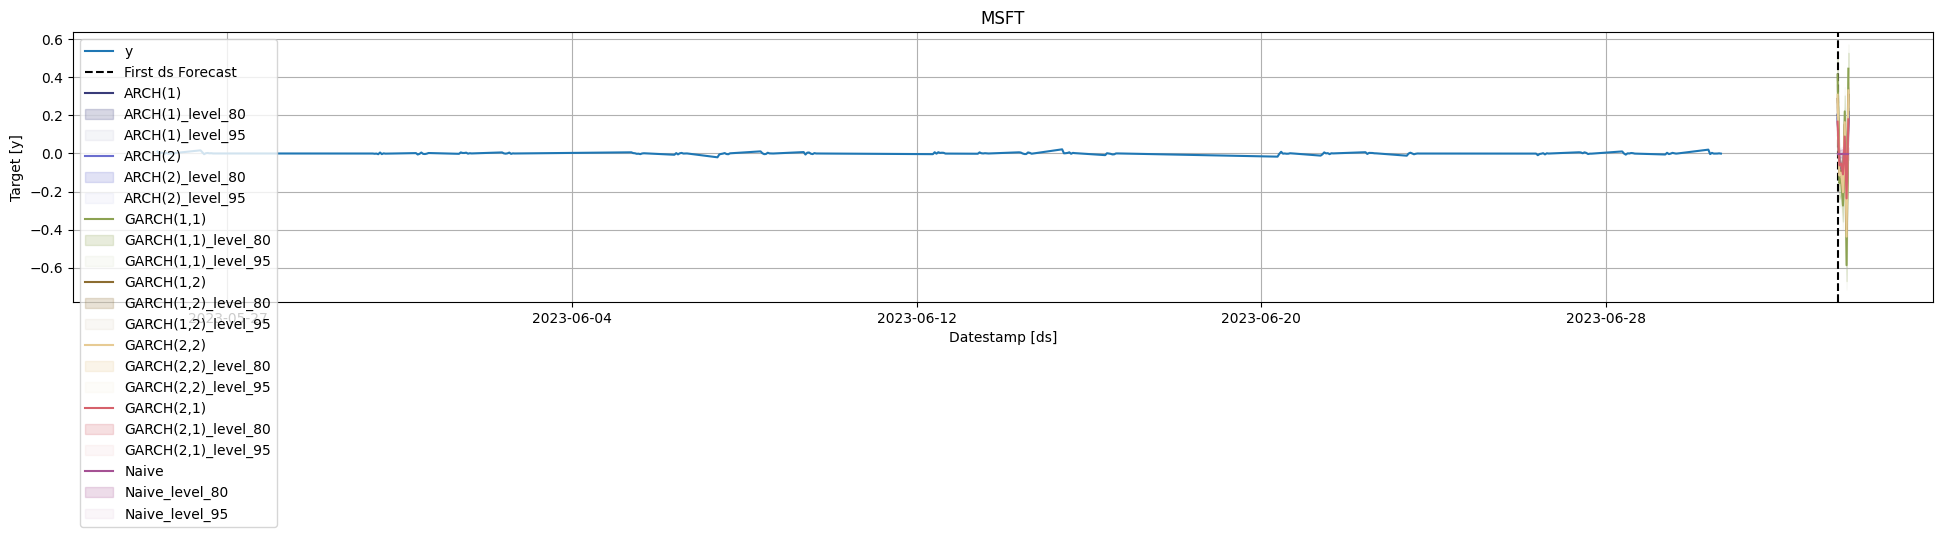

In [81]:
StatsForecast.plot(returns.tail(200), forecasts, level=levels)